## Crux of the issue for nonlinear filtering: hard to find a good representation of a PDF transformed through a general nonlinearity

In [1]:
import os
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material.py

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

#https://filterpy.readthedocs.io/en/latest/
try:
    import filterpy
except:    
    %pip install filterpy
    !pip install filterpy
    !git clone https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python.git
import filterpy
from filterpy.kalman import KalmanFilter, ExtendedKalmanFilter, MerweScaledSigmaPoints, unscented_transform
from filterpy.kalman import UnscentedKalmanFilter as UKF

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Arial',style='normal', size=10)

from numpy.random import multivariate_normal
np.random.seed(400)

Running Python: 3.8.16


In [2]:
# for plotting an uncertai!pwdnty ellipse
def plot_ellipse(xe,QI): # for showing the progress
    t_max = 100
    t = np.linspace(0, 2*np.pi, t_max)
    a = QI[0,0]
    b = QI[0,1]
    c = QI[1,1]
    lam1 = np.sqrt((a+c)/2+np.sqrt(((a-c)/2)**2+b**2))
    lam2 = np.sqrt((a+c)/2-np.sqrt(((a-c)/2)**2+b**2))

    if ((abs(b) < 1e-10) & (a >= c)):
        phi = 0
    elif ((b == 0) & (a < c)):
        phi = np.pi/2
    else:
        phi = np.arctan2(lam1**2-a,b)

    Ellipse_xh = np.zeros((t_max,2))
    Ellipse_xh[:,0] = np.ones((1,t_max))*xe[0,0]+lam1*np.cos(t)*np.cos(phi)-lam2*np.sin(t)*np.sin(phi)
    Ellipse_xh[:,1] = np.ones((1,t_max))*xe[1,0]+lam1*np.cos(t)*np.sin(phi)+lam2*np.sin(t)*np.cos(phi)
    return Ellipse_xh

In [3]:
Nx = 2
Ns = 2*Nx + 1 
sx,sy = sym.symbols('x,y')

def my_plot(case = 0):
    file = 'UT'+str(case)+'.png'
    if (case == 0):
        f1 = sym.atan2(sy,sx)  
        f2 = sym.sqrt(sx**2+sy**2)  
        mean = (40., 1.)
        Q = np.array([[12., 24.], [24., 50.]])
        print('\nftns: atan2 and sqrt\n')
    elif (case == 1):
        f1 = sx*sym.cos(sy)
        f2 = sx*sym.sin(sy) 
        mean = (1.00, np.pi/2)
        Q = np.diag([.001**2, .04**2])
        print('\nftns: cos and sin\n')
    elif (case == 2):
        f1 = (1+sx)*(2+sy)
        f2 = 0.1*sx**2+sy**2 
        mean = (1., 2.)
        Q = np.array([[10., 5.], [5., 12.]])
        print('\nftns: Quadratic and Quartic\n')

    x0 = np.vstack(mean)
    numfun1 = sym.lambdify([sx,sy],f1) 
    numfun2 = sym.lambdify([sx,sy],f2) 
    gradfun1 = [sympy.diff(f1,var) for var in (sx,sy)]
    gradfun2 = [sympy.diff(f2,var) for var in (sx,sy)]
    numgradfun1 = sympy.lambdify([sx,sy],gradfun1)
    numgradfun2 = sympy.lambdify([sx,sy],gradfun2)

    def h_fun(x, y):
        return np.array([numfun1(x,y), numfun2(x,y)])

    def H_fun(x,y):
        T1 = numgradfun1(x,y)
        T2 = numgradfun2(x,y)
        return np.array([[T1[0][0], T1[1][0]],[T2[0][0], T2[1][0]]])

    #generate random points
    xs, ys = multivariate_normal(mean=mean, cov=Q, size=10000).T
    fxs, fys = h_fun(xs,ys)
    data_mean = np.array([np.mean(xs), np.mean(ys)])
    fdata_mean = np.array([np.mean(fxs), np.mean(fys)])

    H = H_fun(x0[0],x0[1])
    x_lin = h_fun(x0[0],x0[1])
    Q_lin = H@Q@H.T
    Ellipse_Q = plot_ellipse(x0,Q)
    Ellipse_Q_lin = plot_ellipse(x_lin,Q_lin)

    # create sigma points and weights
    points = MerweScaledSigmaPoints(n=Nx, alpha=.5, beta=2., kappa=3-Nx)
    sigmas = points.sigma_points(mean, Q)

    ### pass through nonlinear function
    sigmas_f = np.empty((Ns, Nx))
    ukf_mean = 0
    for i in range(Ns):
        sigmas_f[i] = h_fun(sigmas[i, 0], sigmas[i ,1])
        ukf_mean += points.Wm[i]*sigmas_f[i] 

    ### use unscented transform to get new mean and covariance
    #ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)
    ukf_cov = 0
    for i in range(Ns):
        temp = sigmas_f[i] - ukf_mean
        ukf_cov += points.Wc[i]*np.outer(temp,temp) 

    Ellipse_ukf = plot_ellipse(np.vstack(ukf_mean),ukf_cov)

    print(f'Mean of transformed data',fdata_mean)
    print(f'Linear mean             ',x_lin.T.flatten())
    print(f'UKF Mean                ',ukf_mean)
    print(f'Error of Linear mean    ',fdata_mean.flatten()-x_lin.T.flatten())
    print(f'Error of UKF mean       ',fdata_mean-ukf_mean)

    fig = plt.figure(case,figsize=(12,6))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(xs,ys,'.',ms=1)
    ax1.plot(sigmas[:,0], sigmas[:,1],'rs',ms=6,label=r'Sigma pts');
    ax1.plot(data_mean[0], data_mean[1],'ys',ms=5,label=r'Data Mean');
    ax1.plot(Ellipse_Q[:,0],Ellipse_Q[:,1],'k:',label=r'$Q$')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend(loc='best',prop=font)
    plt.grid()

    ax2.plot(fxs,fys,'.',ms=1)
    ax2.plot(sigmas_f[:,0], sigmas_f[:,1],'rs',ms=6,label=r'Trans Sigma pts');
    ax2.plot(ukf_mean[0], ukf_mean[1],'ko',ms=8,label=r'Mean: UKF');
    ax2.plot(Ellipse_ukf[:,0],Ellipse_ukf[:,1],'k--',label=r'Q: UKF')
    ax2.plot(fdata_mean[0], fdata_mean[1],'ys',ms=5,label=r'Mean: Trans Data');
    ax2.set_ylabel('f2(x,y)')
    ax2.set_xlabel('f1(x,y)')
    ax2.grid()
    ax2.plot(x_lin[0], x_lin[1],'cs',ms=5,label=r'Mean: Linear');
    ax2.plot(Ellipse_Q_lin[:,0],Ellipse_Q_lin[:,1],'c--',label=r'Q: Linear')
    ax2.legend(loc='best',prop=font)
    plt.subplots_adjust(left=0.1, 
                        bottom=0.1,  
                        right=0.9,  
                        top=0.9,  
                        wspace=0.4,  
                        hspace=0.4)     
    if (case == 2):
        ax2.set_xlim([-20, 75])
        ax2.set_ylim([-20, 75])
    elif (case == 0):
        ax2.set_xlim([-.25, .4])
        ax2.set_ylim([35, 45])

    plt.savefig('figs/'+file,dpi=600, format="png",transparent=True)
    plt.show()



ftns: cos and sin

Mean of transformed data [ 0.0003  0.9992]
Linear mean              [ 0.0000  1.0000]
UKF Mean                 [ 0.0000  0.9992]
Error of Linear mean     [ 0.0003 -0.0008]
Error of UKF mean        [ 0.0003  0.0000]


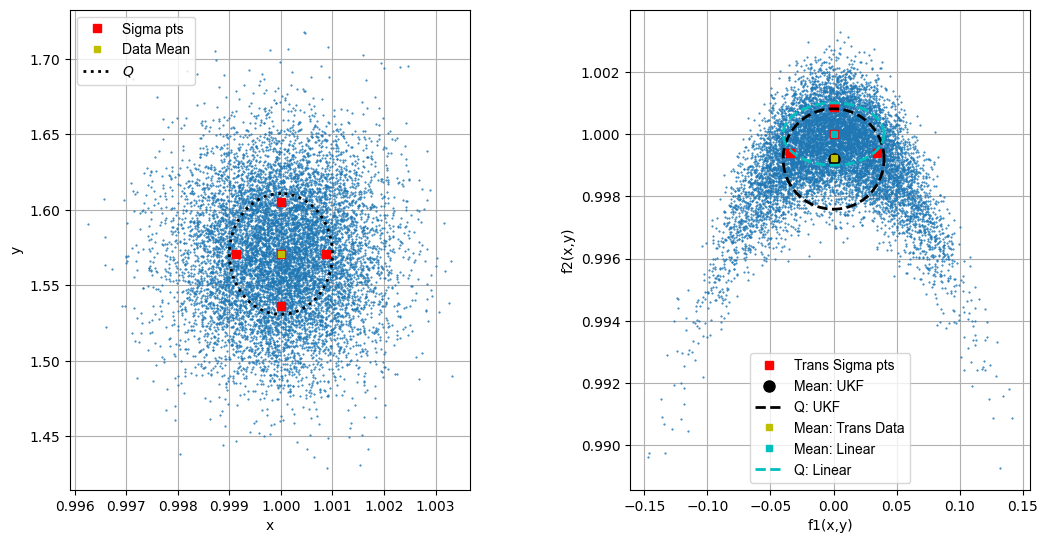

In [4]:
my_plot(1)


ftns: atan2 and sqrt

Mean of transformed data [ 0.0114  40.6306]
Linear mean              [ 0.0250  40.0125]
UKF Mean                 [ 0.0097  40.6224]
Error of Linear mean     [-0.0136  0.6181]
Error of UKF mean        [ 0.0017  0.0082]


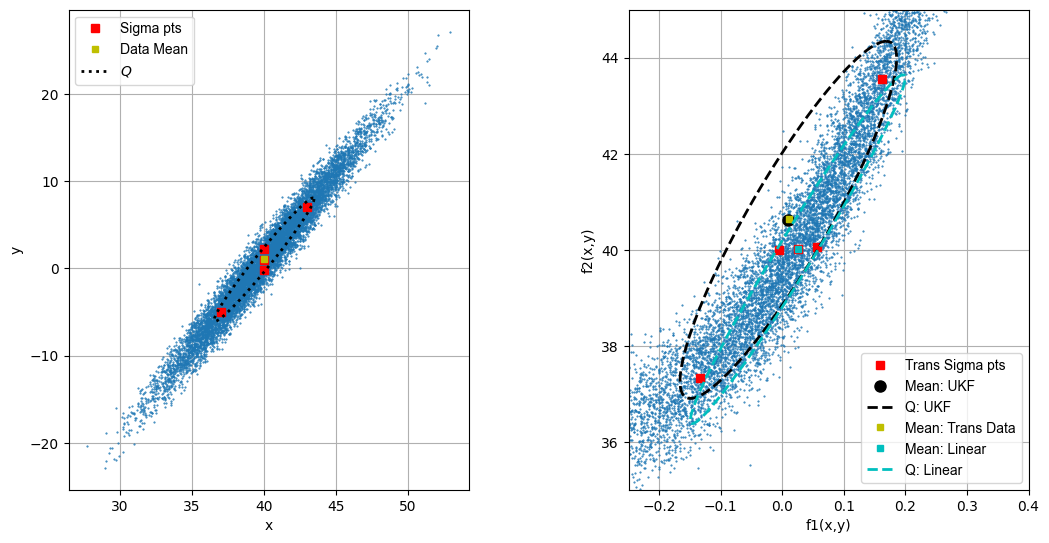

In [5]:
my_plot(0)


ftns: Quadratic and Quartic

Mean of transformed data [ 13.2343  17.1797]
Linear mean              [ 8.0000  4.1000]
UKF Mean                 [ 13.0000  17.1000]
Error of Linear mean     [ 5.2343  13.0797]
Error of UKF mean        [ 0.2343  0.0797]


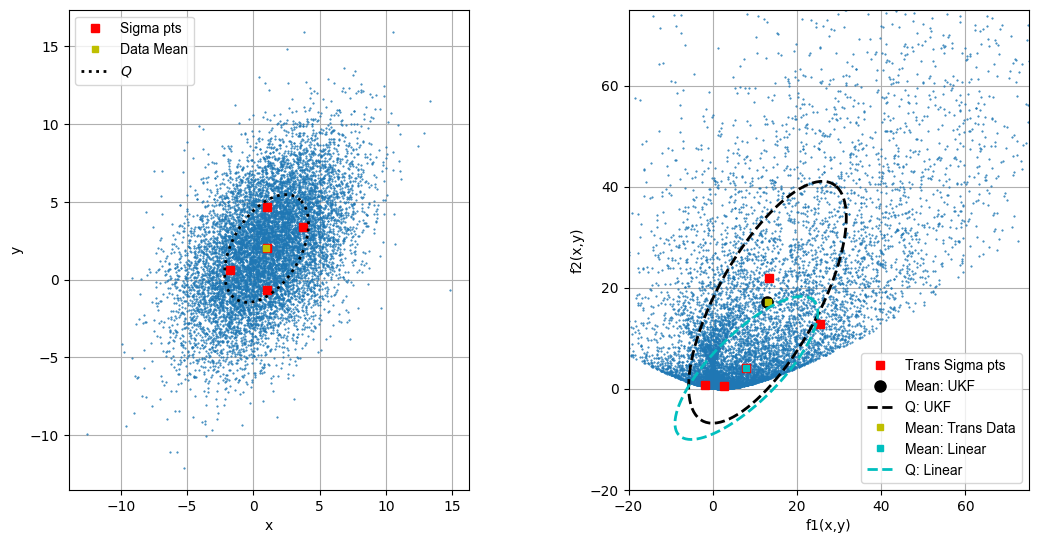

In [6]:
my_plot(2)